# MNIST 모델 pytorch

In [1]:
import numpy as np # 기본적인 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 그림이나 그래프를 그리기 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리
import math # 수학 계산을 위한 라이브러

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리
import torch.nn.functional as F # torch에서 수학적인 function을 쉽게 불러오기 위한 라이브러리

import torchvision.transforms as T # 이미지의 다양성을 주기 위한 라이브러리
import torchvision # torch에서 이미지를 처리하기 위한 라이브러
import torchvision.utils as vutils # torch로 구성된 이미지를 쉽게 구성하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 정확도 성능지표 측정

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
# Hyper parameter
patience = 3
verbose = True

device = 'cpu' # gpu 설정 -> m1은 불가능 -> cpu로 설정

In [29]:
# 샘플 이미지 구조의 텐서 생성
BATCH_SIZE = 16
# (채널, 높이, 너비) -> tensorflow의 순서와 다르다.
# batchsize는 없어도 괜찮다.
sample = torch.randn(BATCH_SIZE, 3, 224, 224)
conv = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
# ((I + 2xP - K )/ S) + 1  = O; ((224 + (2 x 0) - 5) / 1) + 1 = 220
re = conv(sample)
print(len(re.detach().numpy()[0]))

6


# Custom CNN 구현

### CNN class 생성

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.num_classes = 10

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Dropout(0.2),
            torch.nn.Flatten(),
            torch.nn.Linear(28*28*64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.layer(x)

        return out
    
    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [39]:
num_classes = 10
dropout_ratio = 0.5
model = CNN().to(device)
model.count_parameters() # 참고로 DNN 구현(2)에 있는 모델은 약 57만개의 파라미터, 반면에 CNN은 layer 가 DNN 보다 하나 더 많음에도 불구하고, 훨씬 적음

520586

### 모델 학습

In [31]:
# 데이터를 불러올 때, 필요한 변환(transform)을 정의합니다.
mnist_transform = T.Compose([
    T.ToTensor(), # 텐서 형식으로 변환
])

In [32]:
# torchvision 라이브러리를 사용하여 MNIST 데이터 셋을 불러옵니다.
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True) # test dataset 다운로드

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4499988.77it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 144085.83it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1575844.49it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1220640.02it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



In [33]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  48000
Validation dataset 개수 :  12000


In [34]:
# 앞서 선언한 Dataset을 인자로 주어 DataLoader를 선언합니다.
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [41]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  tbar = tqdm(dataloader)
  for images, labels in tbar:
      images = images.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(images)
      loss = criterion(outputs, labels)

      # 역전파 및 가중치 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()

      # tqdm의 진행바에 표시될 설명 텍스트를 설정
      tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

In [42]:

def evaluation(model, dataloader, val_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      tbar = tqdm(dataloader)
      for images, labels in tbar:
          images = images.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(images)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()

          # tqdm의 진행바에 표시될 설명 텍스트를 설정
          tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(val_dataset)

  return model, valid_loss, valid_accuracy

In [43]:
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [44]:
num_epochs = 100
patience = 3
model_name = 'exp1'

lr = 1e-3
criterion = nn.NLLLoss() # NLL loss 후 softmax 를 취하면 CrossEntropy Loss 를 취한 것과 동일하게 됨
optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print('Valid max accuracy : ', valid_max_accuracy)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.1405, Train Accuracy: 0.9592 Valid Loss: 0.0590, Valid Accuracy: 0.9829


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.0480, Train Accuracy: 0.9849 Valid Loss: 0.0533, Valid Accuracy: 0.9843


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.0336, Train Accuracy: 0.9891 Valid Loss: 0.0469, Valid Accuracy: 0.9872


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0269, Train Accuracy: 0.9914 Valid Loss: 0.0470, Valid Accuracy: 0.9878


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0197, Train Accuracy: 0.9935 Valid Loss: 0.0591, Valid Accuracy: 0.9852


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0150, Train Accuracy: 0.9952 Valid Loss: 0.0490, Valid Accuracy: 0.9870
Early stopping
Valid max accuracy :  0.9878333333333333


In [47]:
model.load_state_dict(torch.load("./model_exp1.pt")) # 모델 불러오기
model = model.to('cpu')
model.eval() # model 모드 설정
total_labels = []
total_preds = []

# 가중치 업데이트 방지
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels

        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Custom CNN model accuracy : ", custom_cnn_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

Custom CNN model accuracy :  0.9879


In [48]:
total_labels

array([7, 2, 1, ..., 4, 5, 6])

# 결과 확인

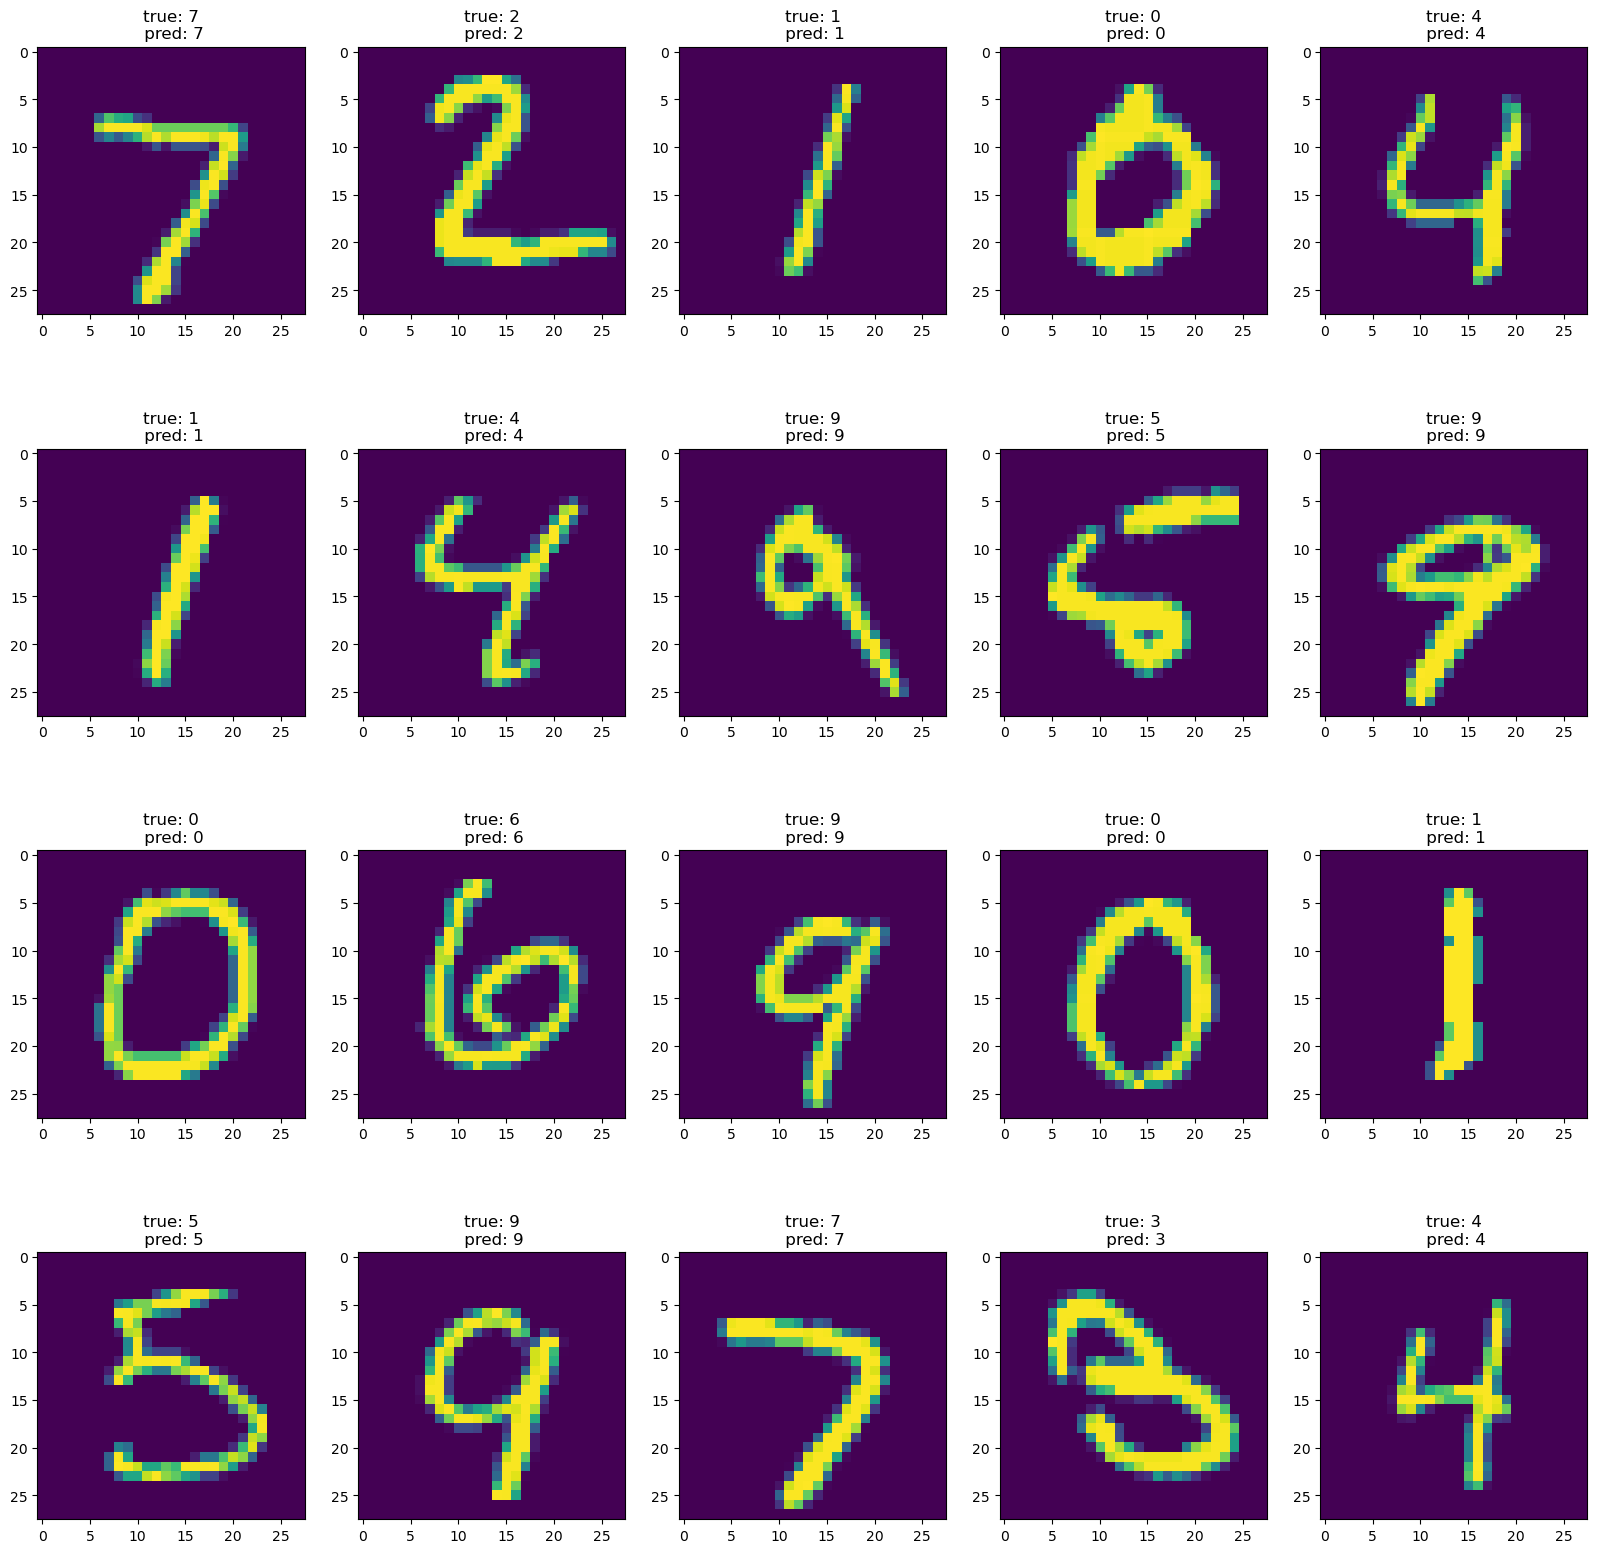

In [91]:
plt.figure(figsize=(20, 20))

for i in range(20):
    image = test_dataset[i][0].squeeze().numpy()
    label = test_dataset[i][1]
    pred = total_labels[i]

    ax = plt.subplot(4, 5, i+1)
    plt.imshow(image)
    plt.title(f'true: {label}\n pred: {pred}')